In [1]:
import os
import numpy as np

import torch

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_theme()

from source.constants import RESULTS_PATH, PLOTS_PATH
from source.data.face_detection import get_fair_face, get_utk
from source.utils.metrics import accuracy, aod, eod, spd

os.makedirs(PLOTS_PATH, exist_ok=True)

/system/apps/userenv/kschweig/quam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
method_seeds = [42, 142, 242, 342, 442]
dseed = 42

model = ["resnet18", "resnet34", "resnet50"][2]

targets = ["age", "gender", "race (old)", "race"]
# predicting race does not give high unfairness (with either pa) for eod and aod
# predicting gender also not too nice (only unfairness with age)
target = 0 # 0, 1, 2, 3
pa = 1 # 0, 1, 2, 3

n_samples = 2_000

In [3]:
# no need to define targets and protected attributes, are queried directly afterwards
ff_train_ds, ff_test_ds = get_fair_face(binarize=True, augment=False)
utk_test_ds = get_utk(binarize=True)

run_path = os.path.join(RESULTS_PATH, f"fairface_target{target}_{model}_mseed{method_seeds[0]}_dseed{dseed}")
fair_inds = torch.load(os.path.join(run_path, "fair_inds.pt"))
val_inds = torch.load(os.path.join(run_path, "val_inds.pt"))

print(len(fair_inds), len(val_inds), len(ff_test_ds), len(utk_test_ds))

# get targets and protected attributes
y_fair_t = ff_train_ds.targets[target, fair_inds]
a_fair_t = ff_train_ds.targets[pa, fair_inds]
y_val_t = ff_train_ds.targets[target, val_inds]
a_val_t = ff_train_ds.targets[pa, val_inds]
y_ff_test_t = ff_test_ds.targets[target]
a_ff_test_t = ff_test_ds.targets[pa]
y_utk_test_t = utk_test_ds.targets[target]
a_utk_test_t = utk_test_ds.targets[pa]

# get fraction of protected attribute for testsets
p_a_ff_test = a_ff_test_t.float().mean().item() * 100
p_a_utk_test = a_utk_test_t.float().mean().item() * 100
print(p_a_ff_test, p_a_utk_test)

10843 10843 10954 23705
52.875661849975586 52.27167010307312


In [4]:
# load probits
fair_probits, val_probits, ff_test_probits, utk_test_probits = list(), list(), list(), list()
for mseed in method_seeds:
    path = os.path.join(RESULTS_PATH, f"fairface_target{target}_{model}_mseed{mseed}_dseed{dseed}")

    fair_probits.append(torch.load(os.path.join(path, f"fair_probits_t{target}.pt")))
    val_probits.append(torch.load(os.path.join(path, f"val_probits_t{target}.pt")))
    ff_test_probits.append(torch.load(os.path.join(path, f"ff_test_probits_t{target}.pt")))
    utk_test_probits.append(torch.load(os.path.join(path, f"utk_test_probits_t{target}.pt")))

In [5]:
# calculate accuracies and fairness measures
ff_test_accs, utk_test_accs = list(), list()
ff_test_spds, utk_test_spds = list(), list()
ff_test_eods, utk_test_eods = list(), list()
ff_test_aods, utk_test_aods = list(), list()

for m in range(len(method_seeds)):
    ff_test_accs.append([accuracy(p.argmax(dim=1), y_ff_test_t) for p in ff_test_probits[m]])
    utk_test_accs.append([accuracy(p.argmax(dim=1), y_utk_test_t) for p in utk_test_probits[m]])

    ff_test_spds.append([spd(p.argmax(dim=1), a_ff_test_t) for p in ff_test_probits[m]])
    utk_test_spds.append([spd(p.argmax(dim=1), a_utk_test_t) for p in utk_test_probits[m]])
    
    ff_test_eods.append([eod(p.argmax(dim=1), y_ff_test_t, a_ff_test_t) for p in ff_test_probits[m]])
    utk_test_eods.append([eod(p.argmax(dim=1), y_utk_test_t, a_utk_test_t) for p in utk_test_probits[m]])

    ff_test_aods.append([aod(p.argmax(dim=1), y_ff_test_t, a_ff_test_t) for p in ff_test_probits[m]])
    utk_test_aods.append([aod(p.argmax(dim=1), y_utk_test_t, a_utk_test_t) for p in utk_test_probits[m]])

In [6]:
ff_test_m_accs, ff_test_rm_accs, utk_test_m_accs, utk_test_rm_accs = list(), list(), list(), list()
ff_test_m_spds, ff_test_rm_spds, utk_test_m_spds, utk_test_rm_spds = list(), list(), list(), list()
ff_test_m_eods, ff_test_rm_eods, utk_test_m_eods, utk_test_rm_eods = list(), list(), list(), list()
ff_test_m_aods, ff_test_rm_aods, utk_test_m_aods, utk_test_rm_aods = list(), list(), list(), list()
rng = np.random.default_rng(seed=42)

for m in range(len(method_seeds)):
    ff_test_m_accs.append(accuracy(torch.mean(ff_test_probits[m], dim=0).argmax(dim=1), y_ff_test_t))
    ff_test_m_spds.append(spd(torch.mean(ff_test_probits[m], dim=0).argmax(dim=1), a_ff_test_t))
    ff_test_m_eods.append(eod(torch.mean(ff_test_probits[m], dim=0).argmax(dim=1), y_ff_test_t, a_ff_test_t))
    ff_test_m_aods.append(aod(torch.mean(ff_test_probits[m], dim=0).argmax(dim=1), y_ff_test_t, a_ff_test_t))

    utk_test_m_accs.append(accuracy(torch.mean(utk_test_probits[m], dim=0).argmax(dim=1), y_utk_test_t))
    utk_test_m_spds.append(spd(torch.mean(utk_test_probits[m], dim=0).argmax(dim=1), a_utk_test_t))
    utk_test_m_eods.append(eod(torch.mean(utk_test_probits[m], dim=0).argmax(dim=1), y_utk_test_t, a_utk_test_t))
    utk_test_m_aods.append(aod(torch.mean(utk_test_probits[m], dim=0).argmax(dim=1), y_utk_test_t, a_utk_test_t))

    
    ff_test_rm_accs_, ff_test_rm_spds_, ff_test_rm_eods_, ff_test_rm_aods_ = list(), list(), list(), list()
    utk_test_rm_accs_, utk_test_rm_spds_, utk_test_rm_eods_, utk_test_rm_aods_ = list(), list(), list(), list()

    for i in range(n_samples):
        
        # include individual models
        if i < len(fair_probits[0]):
            sample = torch.zeros(len(fair_probits[0]), 1, 1)
            sample[i] = 1
        # sample uniform from simplex
        else:
            sample = torch.as_tensor(np.random.dirichlet(np.ones(len(fair_probits[0])))).reshape(-1, 1, 1)

        ff_test_rm_accs_.append(accuracy(torch.sum((ff_test_probits[m] * sample), dim=0).argmax(dim=1), y_ff_test_t))
        ff_test_rm_spds_.append(spd(torch.sum((ff_test_probits[m] * sample), dim=0).argmax(dim=1), a_ff_test_t))
        ff_test_rm_eods_.append(eod(torch.sum((ff_test_probits[m] * sample), dim=0).argmax(dim=1), y_ff_test_t, a_ff_test_t))
        ff_test_rm_aods_.append(aod(torch.sum((ff_test_probits[m] * sample), dim=0).argmax(dim=1), y_ff_test_t, a_ff_test_t))

        utk_test_rm_accs_.append(accuracy(torch.sum((utk_test_probits[m] * sample), dim=0).argmax(dim=1), y_utk_test_t))
        utk_test_rm_spds_.append(spd(torch.sum((utk_test_probits[m] * sample), dim=0).argmax(dim=1), a_utk_test_t))
        utk_test_rm_eods_.append(eod(torch.sum((utk_test_probits[m] * sample), dim=0).argmax(dim=1), y_utk_test_t, a_utk_test_t))
        utk_test_rm_aods_.append(aod(torch.sum((utk_test_probits[m] * sample), dim=0).argmax(dim=1), y_utk_test_t, a_utk_test_t))

    ff_test_rm_accs.append(ff_test_rm_accs_)
    ff_test_rm_spds.append(ff_test_rm_spds_)
    ff_test_rm_eods.append(ff_test_rm_eods_)
    ff_test_rm_aods.append(ff_test_rm_aods_)

    utk_test_rm_accs.append(utk_test_rm_accs_)
    utk_test_rm_spds.append(utk_test_rm_spds_)
    utk_test_rm_eods.append(utk_test_rm_eods_)
    utk_test_rm_aods.append(utk_test_rm_aods_)

ff_test_rm_accs = np.array(ff_test_rm_accs)
ff_test_rm_spds = np.array(ff_test_rm_spds)
ff_test_rm_eods = np.array(ff_test_rm_eods)
ff_test_rm_aods = np.array(ff_test_rm_aods)

utk_test_rm_accs = np.array(utk_test_rm_accs)
utk_test_rm_spds = np.array(utk_test_rm_spds)
utk_test_rm_eods = np.array(utk_test_rm_eods)
utk_test_rm_aods = np.array(utk_test_rm_aods)

In [7]:
from scipy.spatial import ConvexHull

def get_convex_hull_points(points):
    hull = ConvexHull(points)

    x_points = points[hull.vertices, 0].tolist()
    x_points.append(points[hull.vertices[0], 0])
    y_points = points[hull.vertices, 1].tolist()
    y_points.append(points[hull.vertices[0], 1])

    return x_points, y_points   

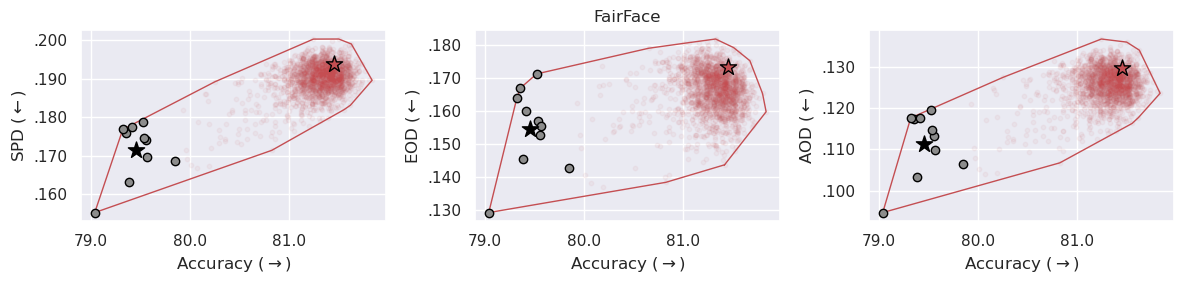

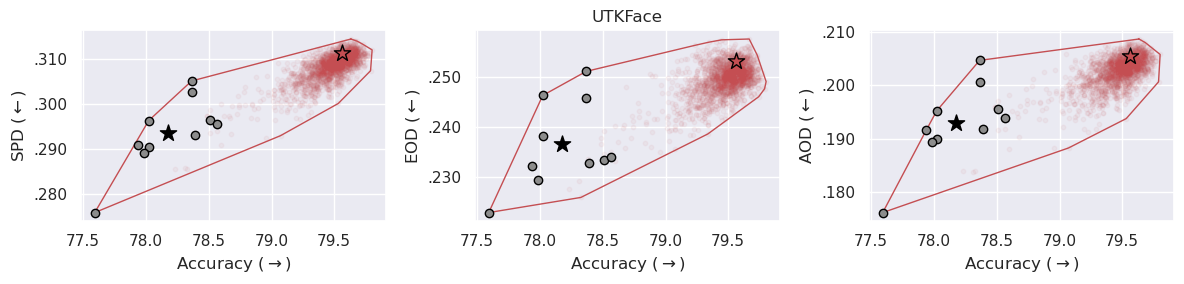

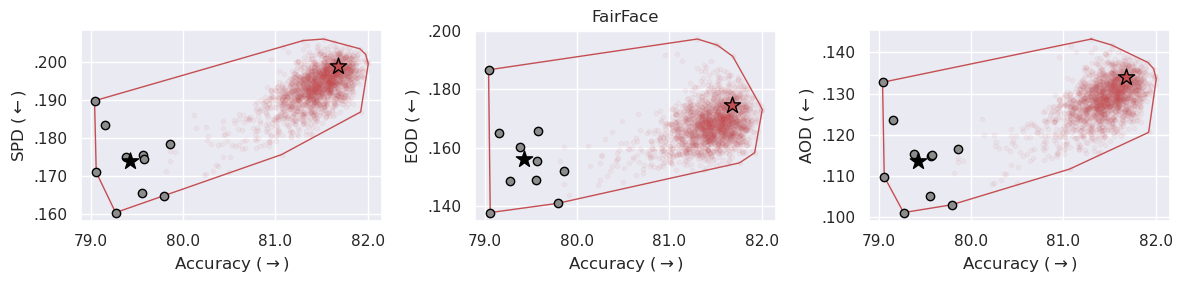

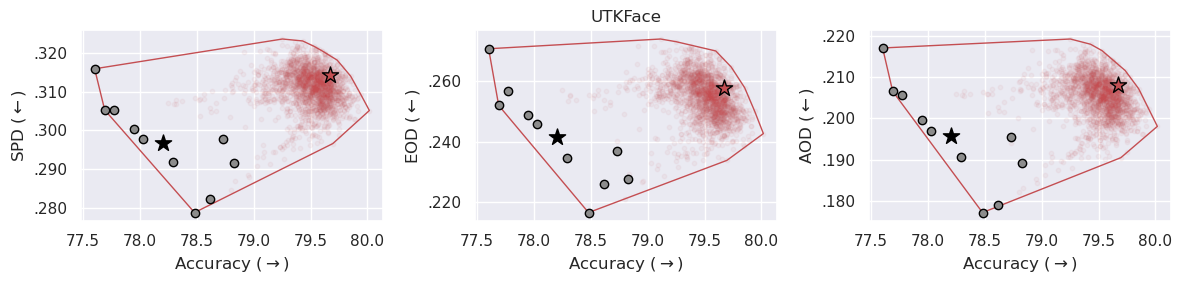

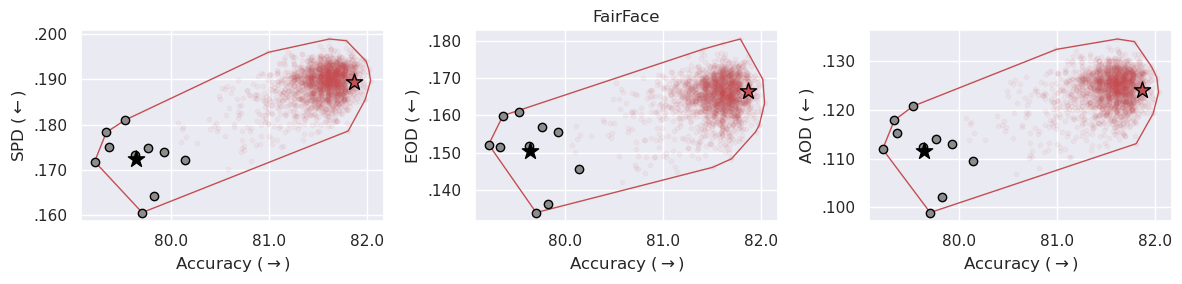

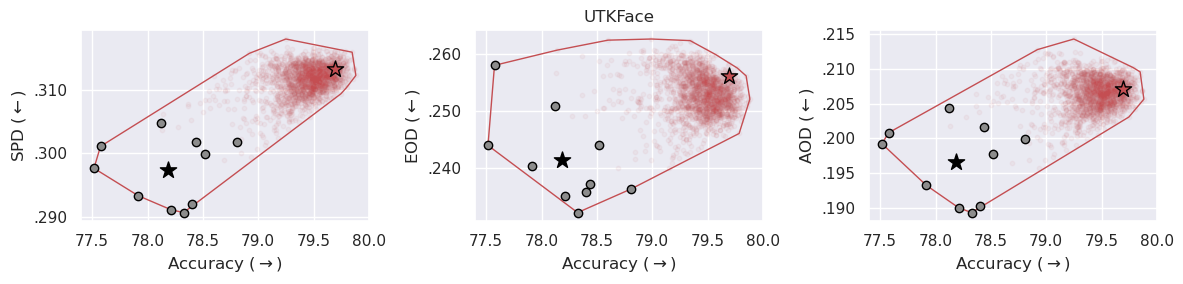

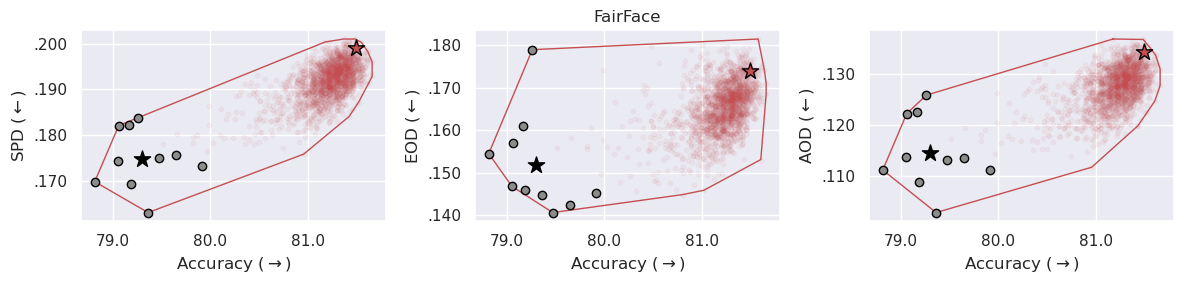

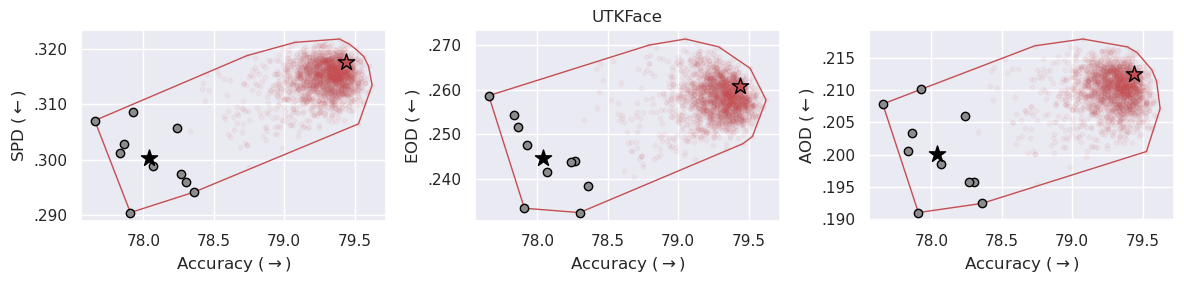

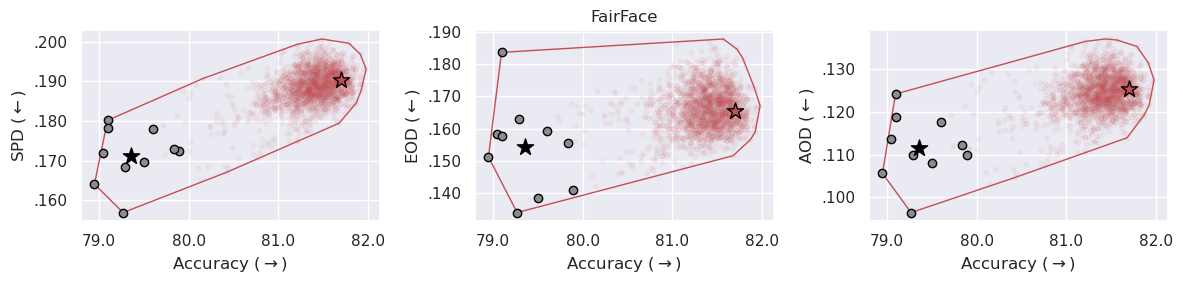

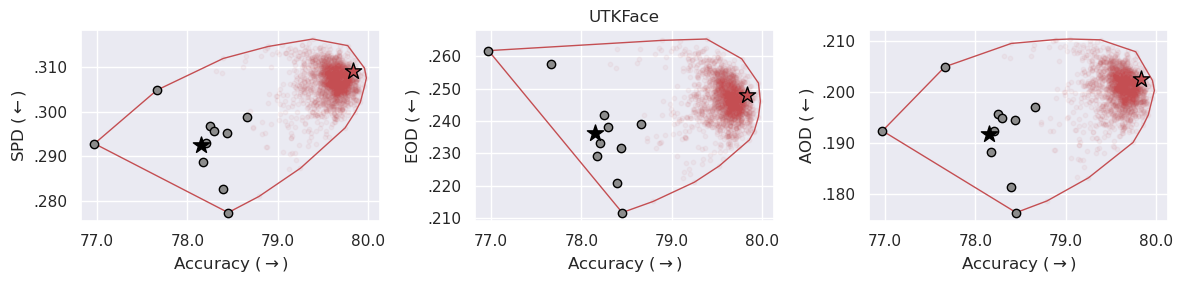

In [25]:
for m, mseed in enumerate(method_seeds):
    f, axs = plt.subplots(1, 3, figsize=(12, 3))
    axs[0].scatter(ff_test_accs[m], ff_test_spds[m], color="C7", edgecolors="black", zorder=99)
    axs[0].scatter(np.mean(ff_test_accs[m]), np.mean(ff_test_spds[m]), marker="*", color="black", s=150, zorder=99)
    axs[0].scatter(ff_test_m_accs[m], ff_test_m_spds[m], marker="*", c="C3", edgecolors="black", s=150, zorder=99)
    axs[0].scatter(ff_test_rm_accs[m], ff_test_rm_spds[m], c="C3", s=10, alpha=0.05)
    x_points, y_points = get_convex_hull_points(np.column_stack((ff_test_rm_accs[m].flatten(), ff_test_rm_spds[m].flatten())))
    axs[0].plot(x_points, y_points, '-', lw=1, c="C3")
    axs[0].set_ylabel("SPD ($\\leftarrow$)")
    axs[1].scatter(ff_test_accs[m], ff_test_eods[m], color="C7", edgecolors="black", zorder=99)
    axs[1].scatter(np.mean(ff_test_accs[m]), np.mean(ff_test_eods[m]), marker="*", c="black", s=150, zorder=99)
    axs[1].scatter(ff_test_m_accs[m], ff_test_m_eods[m], marker="*", c="C3", edgecolors="black", s=150, zorder=99)
    axs[1].scatter(ff_test_rm_accs[m], ff_test_rm_eods[m], c="C3", s=10, alpha=0.05)
    x_points, y_points = get_convex_hull_points(np.column_stack((ff_test_rm_accs[m].flatten(), ff_test_rm_eods[m].flatten())))
    axs[1].plot(x_points, y_points, '-', lw=1, c="C3")
    axs[1].set_ylabel("EOD ($\\leftarrow$)")
    axs[2].scatter(ff_test_accs[m], ff_test_aods[m], color="C7", edgecolors="black", zorder=99)
    axs[2].scatter(np.mean(ff_test_accs[m]), np.mean(ff_test_aods[m]), marker="*", c="black", s=150, zorder=99)
    axs[2].scatter(ff_test_m_accs[m], ff_test_m_aods[m], marker="*", c="C3", edgecolors="black", s=150, zorder=99)
    axs[2].scatter(ff_test_rm_accs[m], ff_test_rm_aods[m], c="C3", s=10, alpha=0.05)
    x_points, y_points = get_convex_hull_points(np.column_stack((ff_test_rm_accs[m].flatten(), ff_test_rm_aods[m].flatten())))
    axs[2].plot(x_points, y_points, '-', lw=1, c="C3")
    axs[2].set_ylabel("AOD ($\\leftarrow$)")

    axs[1].set_title("FairFace")

    for a, ax in enumerate(axs.flatten()):
        ax.set_xlabel("Accuracy ($\\rightarrow$)")
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.1f}"))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}".lstrip("0")))

    f.tight_layout()
    if m == 0:
        plt.savefig(os.path.join(PLOTS_PATH, f"fairface_target{target}_{model}_mseed{mseed}_dseed{dseed}_convex_hull_ff.png"), dpi=300)
    plt.show()

    f, axs = plt.subplots(1, 3, figsize=(12, 3))

    axs[0].scatter(utk_test_accs[m], utk_test_spds[m], color="C7", edgecolors="black", zorder=99)
    axs[0].scatter(np.mean(utk_test_accs[m]), np.mean(utk_test_spds[m]), marker="*", c="black", s=150, zorder=99)
    axs[0].scatter(utk_test_m_accs[m], utk_test_m_spds[m], marker="*", c="C3", edgecolors="black", s=150, zorder=99)
    axs[0].scatter(utk_test_rm_accs[m], utk_test_rm_spds[m], c="C3", s=10, alpha=0.05)
    x_points, y_points = get_convex_hull_points(np.column_stack((utk_test_rm_accs[m].flatten(), utk_test_rm_spds[m].flatten())))
    axs[0].plot(x_points, y_points, '-', lw=1, c="C3")
    axs[0].set_ylabel("SPD ($\\leftarrow$)")
    axs[1].scatter(utk_test_accs[m], utk_test_eods[m], color="C7", edgecolors="black", zorder=99)
    axs[1].scatter(np.mean(utk_test_accs[m]), np.mean(utk_test_eods[m]), marker="*", c="black", s=150, zorder=99)
    axs[1].scatter(utk_test_m_accs[m], utk_test_m_eods[m], marker="*", c="C3", edgecolors="black", s=150, zorder=99)
    axs[1].scatter(utk_test_rm_accs[m], utk_test_rm_eods[m], c="C3", s=10, alpha=0.05)
    x_points, y_points = get_convex_hull_points(np.column_stack((utk_test_rm_accs[m].flatten(), utk_test_rm_eods[m].flatten())))
    axs[1].plot(x_points, y_points, '-', lw=1, c="C3")
    axs[1].set_ylabel("EOD ($\\leftarrow$)")
    axs[2].scatter(utk_test_accs[m], utk_test_aods[m], color="C7", edgecolors="black", zorder=99)
    axs[2].scatter(np.mean(utk_test_accs[m]), np.mean(utk_test_aods[m]), marker="*", c="black", s=150, zorder=99)
    axs[2].scatter(utk_test_m_accs[m], utk_test_m_aods[m], marker="*", c="C3", edgecolors="black", s=150, zorder=99)
    axs[2].scatter(utk_test_rm_accs[m], utk_test_rm_aods[m], c="C3", s=10, alpha=0.05)
    x_points, y_points = get_convex_hull_points(np.column_stack((utk_test_rm_accs[m].flatten(), utk_test_rm_aods[m].flatten())))
    axs[2].plot(x_points, y_points, '-', lw=1, c="C3")
    axs[2].set_ylabel("AOD ($\\leftarrow$)")

    axs[1].set_title("UTKFace")


    for a, ax in enumerate(axs.flatten()):
        ax.set_xlabel("Accuracy ($\\rightarrow$)")
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.1f}"))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}".lstrip("0")))

    f.tight_layout()
    if m == 0:
        plt.savefig(os.path.join(PLOTS_PATH, f"fairface_target{target}_{model}_mseed{mseed}_dseed{dseed}_convex_hull_utk.png"), dpi=300)
    plt.show()